<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the essentials

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import     transforms


In [3]:
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


In [4]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [5]:
import time
import os
import json
import argparse
import copy


In [6]:
import pandas as pd
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score


In [7]:
import matplotlib.pyplot as plt


In [9]:
import cv2
from skimage import io, transform



In [ ]:
# print(os.listdir("../input/kernel4f121f3247"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/kernel4f121f3247'

In [11]:
import seaborn as sns

# Loading Data + EDA

In [13]:
test_csv = pd.read_csv('test.csv')
train_csv = pd.read_csv('train.csv')

In [14]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 366


In [15]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


C:\Users\V S MANOJ KUMAR\AppData\Local\Temp\ipykernel_20256\1735052992.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


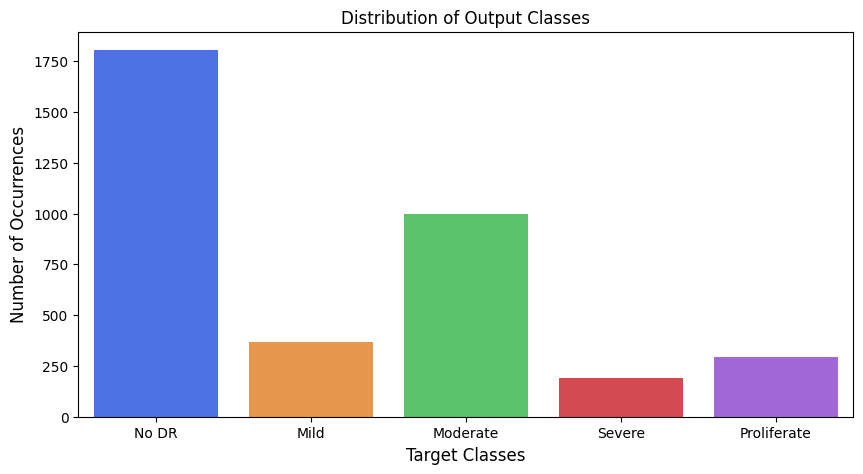

In [18]:
# counts = train_csv['diagnosis'].value_counts()
# class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
# for i,x in enumerate(class_list):
#     counts[x] = counts.pop(i)

# plt.figure(figsize=(10,5))
# sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
# plt.title('Distribution of Output Classes')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Target Classes', fontsize=12)
# plt.show()


counts = train_csv['diagnosis'].value_counts() 
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate'] 
for i, x in enumerate(class_list): 
    counts[x] = counts.pop(i) 
 
plt.figure(figsize=(10, 5)) 
# Fixed: Use keyword arguments instead of positional arguments
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright') 
plt.title('Distribution of Output Classes') 
plt.ylabel('Number of Occurrences', fontsize=12) 
plt.xlabel('Target Classes', fontsize=12) 
plt.show()


# Visualizing Training Data

IndexError: index 0 is out of bounds for axis 0 with size 0

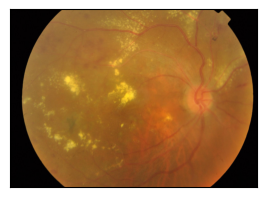

In [35]:
# fig = plt.figure(figsize=(30, 6))
# # display 20 images
# train_imgs = os.listdir(base_dir+"/train_images")
# for idx, img in enumerate(np.random.choice(train_imgs, 16)):
#     ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
#     im = Image.open(base_dir+"/train_images/" + img)
#     plt.imshow(im)
#     lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
#     ax.set_title('Severity: %s'%lab)

# fig = plt.figure(figsize = (30,6))

# Add this line before your plotting code
# Option 1: Using os.path.join (recommended)
import os
base_dir = "."
images_dir = "sampleimages"

fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(os.path.join(base_dir, images_dir))
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, images_dir, img))
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Option 2: Direct path
images_path = "./images/"
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(images_path)
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    im = Image.open(images_path + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)


# Visualizing Test Set

In [27]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images/test_images'

<Figure size 3000x600 with 0 Axes>

# Data Processing

In [0]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [0]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [0]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [0]:
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [0]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
    

In [0]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 1928
46
12
31


In [0]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([2, 0, 0, 3, 2, 3, 1, 2, 0, 0, 2, 0, 0, 0, 2, 4, 2, 0, 2, 4, 2, 0, 1, 0,
        0, 0, 2, 0, 2, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 0,
        0, 3, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 1])


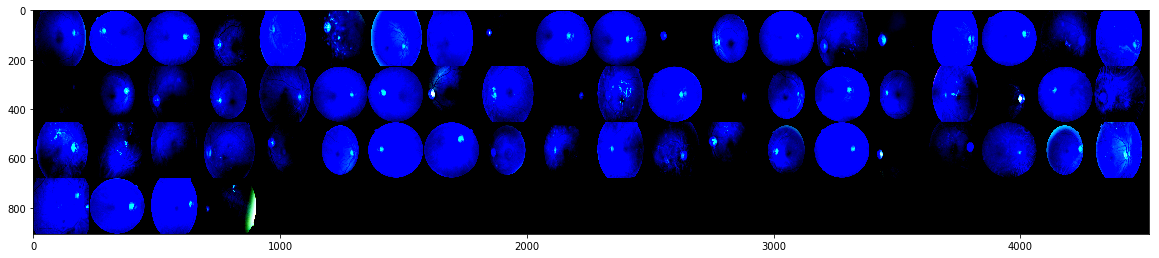

In [0]:
# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

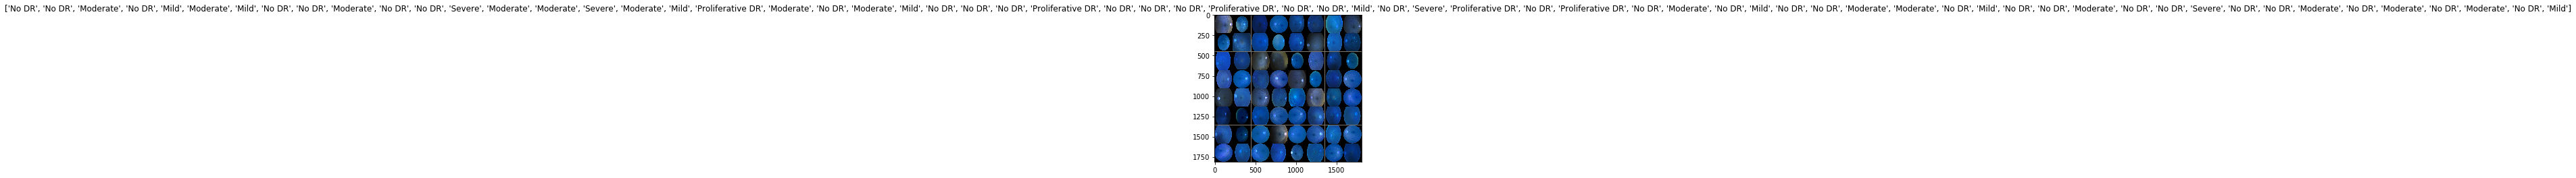

In [0]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [0]:
model_save_name = 'classifier.pt'
path = F"/kaggle/working/{model_save_name}"

In [0]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [0]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [0]:
model = load_model("../input/kernel4f121f3247/classifier.pt")

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [0]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
validation started for 1
Epoch: 1/5..  Training Loss: 0.138..  Valid Loss: 0.115..  Valid Accuracy: 0.958
Validation loss decreased (inf --> 0.114695).  Saving model ...


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site

 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
validation started for 2
Epoch: 2/5..  Training Loss: 0.092..  Valid Loss: 0.122..  Valid Accuracy: 0.960
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
validation started for 3
Epoch: 3/5..  Training Loss: 0.081..  Valid Loss: 0.113..  Valid Accuracy: 0.964
Validation loss decreased (0.114695 --> 0.113338).  Saving model ...
 epoch 4 batch 10 completed
 epoch 4 batch 20 completed
 epoch 4 batch 30 completed
 epoch 4 batch 40 completed
validation started for 4
Epoch: 4/5..  Training Loss: 0.079..  Valid Loss: 0.120..  Valid Accuracy: 0.962
 epoch 5 batch 10 completed
 epoch 5 batch 20 completed
 epoch 5 batch 30 completed
 epoch 5 batch 40 completed
validation started for 5
Epoch: 5/5..  Training Loss: 0.073..  Valid Loss: 0.107..  Valid Accuracy: 0.967
Validation loss decreased (0.113338 --> 0.106542).  Saving 

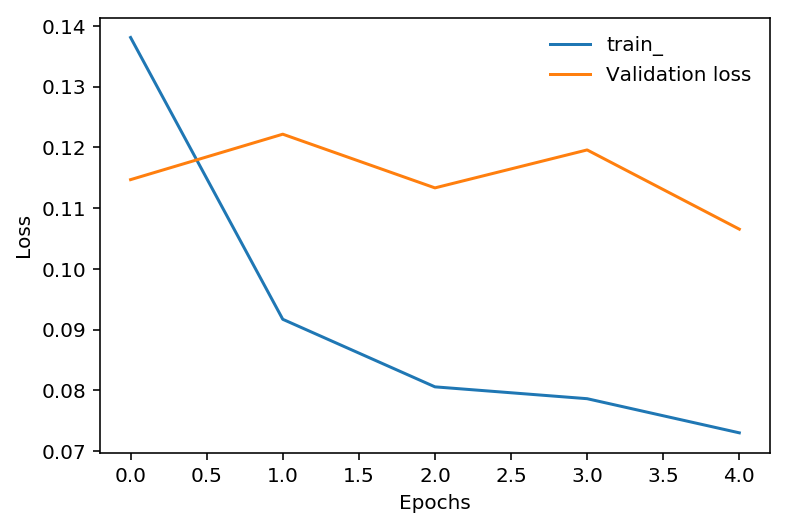

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

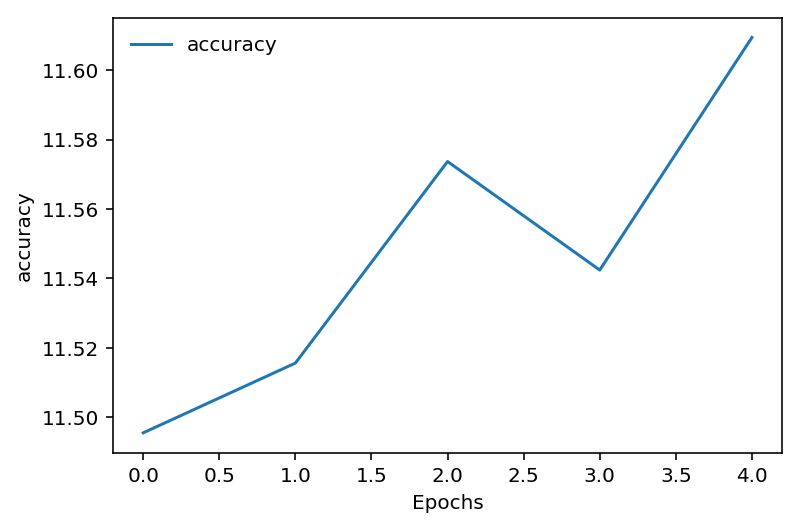

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)